# Imports


In [1]:
# import find_context from baselines/bm25/bm25.py
import random
from urllib import parse
from tqdm import tqdm
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

# Helpful Functions


In [2]:
def compute_mrr(rankings, k_values=[1, 5, 10]):
    mrr_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    mrr_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    # compute MRR for each k
    # and compute confidence intervals for each k
    mrr_at_max = {'score': 0, 'cl': [None, None]}
    mrr_at_max_list = [0 for _ in range(100)]
    
    # extract 100 samples
    for i in range(100):
        sample = random.choices(rankings, k = len(rankings))
        for rank in sample:
            for k in mrr_at_k_lists.keys():
                if rank <= int(k):
                    mrr_at_k_lists[str(k)][i] += (1 / rank) / len(sample)
            mrr_at_max_list[i] += (1 / rank) / len(sample)
    
    # sort values for confidence intervals
    for k in mrr_at_k_lists.keys():
        mrr_at_k_lists[str(k)].sort()
    mrr_at_max_list.sort()
        
    # find mean score and 90% confidence interval
    for k in mrr_at_k_lists.keys():
        mrr_at_k[str(k)]['score'] = np.mean(mrr_at_k_lists[str(k)]) * 1000 // 1 / 1000
        mrr_at_k[str(k)]['cl'] = [mrr_at_k_lists[str(k)][4] * 1000 // 1 / 1000, mrr_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    mrr_at_max['score'] = np.mean(mrr_at_max_list) * 1000 // 1 / 1000
    mrr_at_max['cl'] = [mrr_at_max_list[4] * 1000 // 1 / 1000, mrr_at_max_list[94] * 1000 // 1 / 1000]
    
    # add max to mrr_at_k
    mrr_at_k['max'] = mrr_at_max

    return mrr_at_k

In [3]:
def compute_stratified_mrr(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in tqdm(zip(rankings, categories), total=len(rankings)):
        ranks_stratified[category].append(rank)
        
    discrete_mrr_at_k = {}
        
    for category in categories_values:
        discrete_mrr_at_k[category] = compute_mrr(ranks_stratified[category], k_values)
        
    return discrete_mrr_at_k

In [4]:
def compute_hits(rankings, k_values=[1, 5, 10]):
    hits_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    hits_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    
    # extract 100 samples
    for i in range(100):
        sample = random.choices(rankings, k = len(rankings))
        for rank in sample:
            for k in hits_at_k_lists.keys():
                if rank <= int(k):
                    hits_at_k_lists[str(k)][i] += 1 / len(sample)
    
    # sort values for confidence intervals
    for k in hits_at_k_lists.keys():
        hits_at_k_lists[str(k)].sort()
    
    # find mean score and 90% confidence interval
    for k in hits_at_k_lists.keys():
        hits_at_k[str(k)]['score'] = np.mean(hits_at_k_lists[str(k)]) * 1000 // 1 / 1000
        hits_at_k[str(k)]['cl'] = [hits_at_k_lists[str(k)][4] * 1000 // 1 / 1000, hits_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    
    return hits_at_k

In [5]:
def compute_stratified_hits(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in tqdm(zip(rankings, categories), total=len(rankings)):
        ranks_stratified[category].append(rank)
    
    discrete_hits_at_k = {}
        
    for category in categories_values:
        discrete_hits_at_k[category] = compute_hits(ranks_stratified[category], k_values)
        
    return discrete_hits_at_k

In [6]:
def compute_ndcg(rankings, k_values=[1, 5, 10]):
    ndcg_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    ndcg_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    # compute NDCG for each k
    # and compute confidence intervals for each k
    ndcg_at_max = {'score': 0, 'cl': [None, None]}
    ndcg_at_max_list = [0 for _ in range(100)]
    
    # extract 100 samples
    for i in range(100):
        sample = random.choices(rankings, k = len(rankings))
        for rank in sample:
            for k in ndcg_at_k_lists.keys():
                if rank <= int(k):
                    ndcg_at_k_lists[str(k)][i] += (1 / np.log2(rank + 1)) / len(sample)
            ndcg_at_max_list[i] += (1 / np.log2(rank + 1)) / len(sample)
    
    # sort values for confidence intervals
    for k in ndcg_at_k_lists.keys():
        ndcg_at_k_lists[str(k)].sort()
    ndcg_at_max_list.sort()
        
    # find mean score and 90% confidence interval
    for k in ndcg_at_k_lists.keys():
        ndcg_at_k[str(k)]['score'] = np.mean(ndcg_at_k_lists[str(k)]) * 1000 // 1 / 1000
        ndcg_at_k[str(k)]['cl'] = [ndcg_at_k_lists[str(k)][4] * 1000 // 1 / 1000, ndcg_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    ndcg_at_max['score'] = np.mean(ndcg_at_max_list) * 1000 // 1 / 1000
    ndcg_at_max['cl'] = [ndcg_at_max_list[4] * 1000 // 1 / 1000, ndcg_at_max_list[94] * 1000 // 1 / 1000]
    
    # add max to ndcg_at_k
    ndcg_at_k['max'] = ndcg_at_max
    
    return ndcg_at_k

In [7]:
def compute_stratified_ndcg(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in tqdm(zip(rankings, categories), total=len(rankings)):
        ranks_stratified[category].append(rank)
    
    discrete_ndcg_at_k = {}
        
    for category in categories_values:
        discrete_ndcg_at_k[category] = compute_ndcg(ranks_stratified[category], k_values)
        
    return discrete_ndcg_at_k

# Load data


In [8]:
test_df = pd.read_parquet('test_ranking_scores.parquet')
test_df

,source_title,source_lead,target_title,target_lead,link_context,source_section,context_span_start_index,context_span_end_index,context_sentence_start_index,context_sentence_end_index,...,noise_strategy_neg_18,source_section_neg_18,random_rank,bm25_rank,bm25_mentions_rank,exact_match_rank,fuzzy_match_rank,model_ranking_corruption_rank,model_ranking_no_corruption_rank,model_random_section_rank
0,MBC 3,MBC 3 is a free-to-air children's channel laun...,PAW Patrol,PAW Patrol is a Canadian CGI-animated televisi...,PAW Patrol\nThe Penguins of Madagascar\nRise o...,Programming,105,118,105,119,...,no_mask,Lead,3,4,1,1,20,1,1,1
1,Hezbollah,Hezbollah is an Islamic political party and pa...,Ayatollah Khomeini,Ayatollah Khomeini was born Sayyed Ruhollah Mu...,History,History,8,557,270,370,...,mask_span,Lead,7,20,20,5,14,1,20,1
2,"Austell, Georgia",Austell is a city in Cobb County in the U.S. s...,2020 United States Census,"The 2020 United States Census, known as Census...",Austell is a city in Cobb County in the U.S. s...,Lead,0,166,108,166,...,mask_sentence,Related pages,12,9,4,12,15,1,1,1
3,Organism,An organism is an individual living thing. It ...,Tree of life (biology),The tree of life is a metaphor which expresses...,Origin\nThe project works on the relationships...,Origin,7,358,7,81,...,mask_mention,Lead,8,2,2,12,14,16,1,7
4,Radim Uzel,Radim Uzel was a Czech sexologist and academic...,Academia,Academia is a word for higher education and re...,Radim Uzel (27 March 1940 – 2 May 2022) was a ...,Lead,0,434,0,76,...,no_mask,People,10,2,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Elle Fanning,"Mary Elle Fanning, known as Elle Fanning, is a...",Jill Arrington,"Tiffany ""Jill"" Arrington is an American sports...","Personal life\nFanning was born on April 9, 19...",Personal life,14,714,319,433,...,mask_mention,Lead,6,1,1,12,4,2,1,2
996,Ruth Davidson,Ruth Davidson is a Scottish politician. She wa...,Sunday school,Sunday School is a kind of schooling found in ...,"She was studied at Knowepark Primary School, a...",Early Life,0,615,469,512,...,mask_sentence,Lead,6,2,2,16,1,1,1,2
997,Eiffel Tower,The Eiffel Tower is a landmark in Paris. It wa...,French Revolution,The French Revolution was a time when France w...,"The Eiffel Tower (French: La Tour Eiffel, , IP...",Lead,0,592,205,341,...,no_mask,Background,9,1,1,1,13,2,3,2
998,2022 Copa America Feminina,The 2022 Copa América Femenina will be the 9th...,"Armenia, Colombia","Armenia is a Colombian municipality, capital o...",(2022-07-21)\n2022-07-21\nEstadio Olímpico Pas...,Group stage,88,115,88,115,...,mask_span,Knockout stage,8,16,16,19,14,1,1,1


In [9]:
mask = test_df['link_context_neg_0'] != test_df['link_context_neg_1']
for i in range(0, 19):
    for j in range(i + 1, 19):
        mask = mask & (test_df['link_context_neg_' + str(i)] != test_df['link_context_neg_' + str(j)])
test_df = test_df[mask]

# Apply Model Trained with Listwise Softmax and Corruption Techniques, but with a random section title

## Compute MRR@k, Hits@k, NDCG@k

In [10]:
mrr_at_k_model_random_section = compute_mrr(test_df['model_random_section_rank'].tolist())
stratified_mrr_at_k_model_random_section = compute_stratified_mrr(test_df['model_random_section_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 1534688.62it/s]


In [11]:
hits_at_k_model_random_section = compute_hits(test_df['model_random_section_rank'].tolist())
stratified_hits_at_k_model_random_section = compute_stratified_hits(test_df['model_random_section_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2169841.70it/s]


In [12]:
ndcg_at_k_model_random_section = compute_ndcg(test_df['model_random_section_rank'].tolist())
stratified_ndcg_at_k_model_random_section = compute_stratified_ndcg(test_df['model_random_section_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2134505.85it/s]


In [13]:
rank_std_model_random_section = test_df['model_random_section_rank'].std()
stratified_rank_std_model_random_section = test_df.groupby('noise_strategy')['model_random_section_rank'].std()

# Apply Model Trained with Listwise Softmax and with Corruption Techniques

# Compute MRR@k, Hits@k, NDCG@k

In [14]:
mrr_at_k_model_softmax_corruption = compute_mrr(test_df['model_ranking_corruption_rank'].tolist())
stratified_mrr_at_k_model_softmax_corruption = compute_stratified_mrr(test_df['model_ranking_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2211019.50it/s]

In [15]:
hits_at_k_model_softmax_corruption = compute_hits(test_df['model_ranking_corruption_rank'].tolist())
stratified_hits_at_k_model_softmax_corruption = compute_stratified_hits(test_df['model_ranking_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2158674.22it/s]


In [16]:
ndcg_at_k_model_softmax_corruption = compute_ndcg(test_df['model_ranking_corruption_rank'].tolist())
stratified_ndcg_at_k_model_softmax_corruption = compute_stratified_ndcg(test_df['model_ranking_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2147621.10it/s]


In [17]:
rank_std_model_softmax_corruption = test_df['model_ranking_corruption_rank'].std()
stratified_rank_std_model_softmax_corruption = test_df.groupby('noise_strategy')['model_ranking_corruption_rank'].std().to_dict()

# Apply Model Trained with Listwise Softmax and without Corruption Techniques

# Compute MRR@k, Hits@k, NDCG@k

In [18]:
mrr_at_k_model_softmax_no_corruption = compute_mrr(test_df['model_ranking_no_corruption_rank'].tolist())
stratified_mrr_at_k_model_softmax_no_corruption = compute_stratified_mrr(test_df['model_ranking_no_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2159785.79it/s]


In [19]:
hits_at_k_model_softmax_no_corruption = compute_hits(test_df['model_ranking_no_corruption_rank'].tolist())
stratified_hits_at_k_model_softmax_no_corruption = compute_stratified_hits(test_df['model_ranking_no_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2248956.57it/s]


In [20]:
ndcg_at_k_model_softmax_no_corruption = compute_ndcg(test_df['model_ranking_no_corruption_rank'].tolist())
stratified_ndcg_at_k_model_softmax_no_corruption = compute_stratified_ndcg(test_df['model_ranking_no_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2178859.22it/s]


In [21]:
rank_std_model_softmax_no_corruption = test_df['model_ranking_no_corruption_rank'].std()
stratified_rank_std_model_softmax_no_corruption = test_df.groupby('noise_strategy')['model_ranking_no_corruption_rank'].std().to_dict()

# Apply Random Guesser


## Compute MRR@k, Hits@k, NDCG@k


In [22]:
mrr_at_k_random = compute_mrr(test_df['random_rank'].tolist())
stratified_mrr_at_k_random = compute_stratified_mrr(test_df['random_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2133420.14it/s]


In [23]:
hits_at_k_random = compute_hits(test_df['random_rank'].tolist())
stratified_hits_at_k_random = compute_stratified_hits(test_df['random_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2259862.07it/s]


In [24]:
ndcg_at_k_random = compute_ndcg(test_df['random_rank'].tolist())
stratified_ndcg_at_k_random = compute_stratified_ndcg(test_df['random_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2330168.89it/s]

In [25]:
rank_std_random = test_df['random_rank'].std()
stratified_rank_std_random = test_df.groupby('noise_strategy')['random_rank'].std()

# Apply BM25


## Compute MRR@k, Hits@k, NDCG@k


In [26]:
mrr_at_k_bm25 = compute_mrr(test_df['bm25_rank'].tolist())
stratified_mrr_at_k_bm25 = compute_stratified_mrr(test_df['bm25_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 1757144.53it/s]


In [27]:
hits_at_k_bm25 = compute_hits(test_df['bm25_rank'].tolist())
stratified_hits_at_k_bm25 = compute_stratified_hits(test_df['bm25_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 1923110.50it/s]

In [28]:
ndcg_at_k_bm25 = compute_ndcg(test_df['bm25_rank'].tolist())
stratified_ndcg_at_k_bm25 = compute_stratified_ndcg(test_df['bm25_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 1984999.53it/s]


In [29]:
rank_std_bm25 = test_df['bm25_rank'].std()
stratified_rank_std_bm25 = test_df.groupby('noise_strategy')['bm25_rank'].std().to_dict()

# Apply BM25 with mention knowledge


## Compute MRR@k, Hits@k, NDCG@k


In [30]:
mrr_at_k_bm25_mention = compute_mrr(test_df['bm25_mentions_rank'].tolist())
stratified_mrr_at_k_bm25_mention = compute_stratified_mrr(test_df['bm25_mentions_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2083608.54it/s]


In [31]:
hits_at_k_bm25_mention = compute_hits(test_df['bm25_mentions_rank'].tolist())
stratified_hits_at_k_bm25_mention = compute_stratified_hits(test_df['bm25_mentions_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2023301.50it/s]


In [32]:
ndcg_at_k_bm25_mention = compute_ndcg(test_df['bm25_mentions_rank'].tolist())
stratified_ndcg_at_k_bm25_mention = compute_stratified_ndcg(test_df['bm25_mentions_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2021351.33it/s]


In [33]:
rank_std_bm25 = test_df['bm25_mentions_rank'].std()
stratified_rank_std_bm25_mention = test_df.groupby('noise_strategy')['bm25_mentions_rank'].std().to_dict()

# Apply Exact Matching


## Compute MRR@k, Hits@k, NDCG@k


In [34]:
mrr_at_k_exact = compute_mrr(test_df['exact_match_rank'].tolist())
stratified_mrr_at_k_exact = compute_stratified_mrr(test_df['exact_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2110872.67it/s]

In [35]:
hits_at_k_exact = compute_hits(test_df['exact_match_rank'].tolist())
stratified_hits_at_k_exact = compute_stratified_hits(test_df['exact_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2003010.51it/s]


In [36]:
ndcg_at_k_exact = compute_ndcg(test_df['exact_match_rank'].tolist())
stratified_ndcg_at_k_exact = compute_stratified_ndcg(test_df['exact_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 1886776.43it/s]


In [37]:
rank_std_exact = test_df['exact_match_rank'].std()
stratified_rank_std_exact = test_df.groupby('noise_strategy')['exact_match_rank'].std()

# Apply Fuzzy Matching


## Compute MRR@k, Hits@k, NDCG@k


In [38]:
mrr_at_k_fuzzy = compute_mrr(test_df['fuzzy_match_rank'].tolist())
stratified_mrr_at_k_fuzzy = compute_stratified_mrr(test_df['fuzzy_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2216862.58it/s]

In [39]:
hits_at_k_fuzzy = compute_hits(test_df['fuzzy_match_rank'].tolist())
stratified_hits_at_k_fuzzy = compute_stratified_hits(test_df['fuzzy_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2252580.02it/s]


In [40]:
ndcg_at_k_fuzzy = compute_ndcg(test_df['fuzzy_match_rank'].tolist())
stratified_ndcg_at_k_fuzzy = compute_stratified_ndcg(test_df['fuzzy_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2280752.58it/s]


In [41]:
rank_std_fuzzy = test_df['fuzzy_match_rank'].std()
stratified_rank_std_fuzzy = test_df.groupby('noise_strategy')['fuzzy_match_rank'].std().to_dict()

# Print all results


In [42]:
print(f"Random guesser rank std: {rank_std_random}")
for category in stratified_rank_std_random.keys():
    print(f"\tRandom guesser rank std for {category}: {stratified_rank_std_random[category]}")
print(f"BM25 rank std: {rank_std_bm25}")
for category in stratified_rank_std_bm25.keys():
    print(f"\tBM25 rank std for {category}: {stratified_rank_std_bm25[category]}")
print(f"BM25 mention rank std: {rank_std_bm25}")
for category in stratified_rank_std_bm25_mention.keys():
    print(f"\tBM25 mention rank std for {category}: {stratified_rank_std_bm25_mention[category]}")    
print(f"Exact match rank std: {rank_std_exact}")
for category in stratified_rank_std_exact.keys():
    print(f"\tExact match rank std for {category}: {stratified_rank_std_exact[category]}")
print(f"Fuzzy match rank std: {rank_std_fuzzy}")
for category in stratified_rank_std_fuzzy.keys():
    print(f"\tFuzzy match rank std for {category}: {stratified_rank_std_fuzzy[category]}")
print(f"Model softmax corruption rank std: {rank_std_model_softmax_corruption}")
for category in stratified_rank_std_model_softmax_corruption.keys():
    print(f"\tModel softmax corruption rank std for {category}: {stratified_rank_std_model_softmax_corruption[category]}")
print(f"Model softmax no corruption rank std: {rank_std_model_softmax_no_corruption}")
for category in stratified_rank_std_model_softmax_no_corruption.keys():
    print(f"\tModel softmax no corruption rank std for {category}: {stratified_rank_std_model_softmax_no_corruption[category]}")
print(f"Model softmax random section rank std: {rank_std_model_random_section}")
for category in stratified_rank_std_model_random_section.keys():
    print(f"\tModel softmax random section rank std for {category}: {stratified_rank_std_model_random_section[category]}")

Random guesser rank std: 5.656900611158421
	Random guesser rank std for mask_mention: 5.194467488528689
	Random guesser rank std for mask_sentence: 5.710113304766843
	Random guesser rank std for mask_span: 5.504623285978588
	Random guesser rank std for no_mask: 5.875853941638923
BM25 rank std: 6.845098931306938
	BM25 rank std for mask_mention: 6.384499643570081
	BM25 rank std for mask_sentence: 6.530705514820044
	BM25 rank std for mask_span: 7.1226322009320056
	BM25 rank std for no_mask: 5.88011429380781
BM25 mention rank std: 6.845098931306938
	BM25 mention rank std for mask_mention: 6.376344939308171
	BM25 mention rank std for mask_sentence: 6.554133439266855
	BM25 mention rank std for mask_span: 7.17694841132913
	BM25 mention rank std for no_mask: 5.602282210554249
Exact match rank std: 6.0974649715335865
	Exact match rank std for mask_mention: 6.634085064038632
	Exact match rank std for mask_sentence: 6.479637049211155
	Exact match rank std for mask_span: 5.939324775607234
	Exact m

# Plot results

## Plot aggregated results

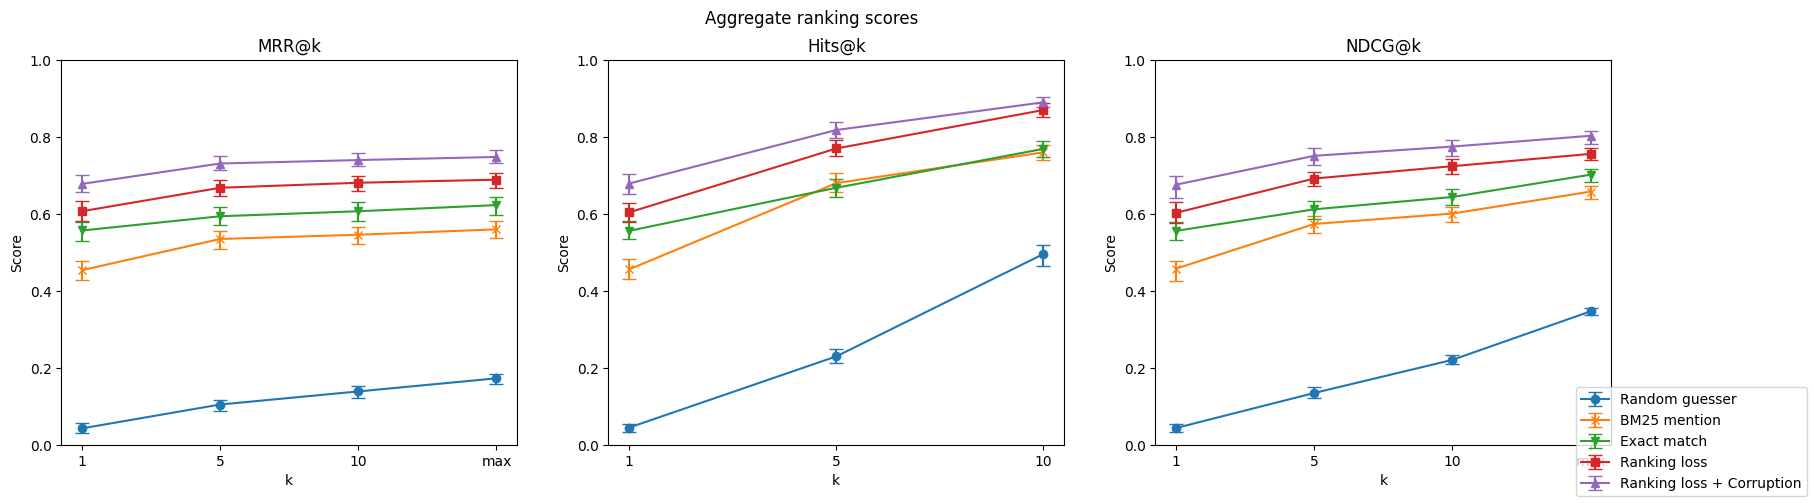

In [43]:
# Plot ranking scores
# create a grid of 1x3 plots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Aggregate ranking scores')    
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('k')
    ax.set_ylabel('Score')
    
axs[0].set_title('MRR@k')
axs[0].errorbar(mrr_at_k_random.keys(), [mrr_at_k_random[k]['score'] for k in mrr_at_k_random.keys()], yerr=[[mrr_at_k_random[k]['score'] - mrr_at_k_random[k]['cl'][0] for k in mrr_at_k_random.keys()], [mrr_at_k_random[k]['cl'][1] - mrr_at_k_random[k]['score'] for k in mrr_at_k_random.keys()]], label='Random guesser', marker='o', capsize=5)
# axs[0].errorbar(mrr_at_k_bm25.keys(), [mrr_at_k_bm25[k]['score'] for k in mrr_at_k_bm25.keys()], yerr=[[mrr_at_k_bm25[k]['score'] - mrr_at_k_bm25[k]['cl'][0] for k in mrr_at_k_bm25.keys()], [mrr_at_k_bm25[k]['cl'][1] - mrr_at_k_bm25[k]['score'] for k in mrr_at_k_bm25.keys()]], label='BM25', marker='x', capsize=5)
axs[0].errorbar(mrr_at_k_bm25_mention.keys(), [mrr_at_k_bm25_mention[k]['score'] for k in mrr_at_k_bm25_mention.keys()], yerr=[[mrr_at_k_bm25_mention[k]['score'] - mrr_at_k_bm25_mention[k]['cl'][0] for k in mrr_at_k_bm25_mention.keys()], [mrr_at_k_bm25_mention[k]['cl'][1] - mrr_at_k_bm25_mention[k]['score'] for k in mrr_at_k_bm25_mention.keys()]], label='BM25 mention', marker='x', capsize=5)
axs[0].errorbar(mrr_at_k_exact.keys(), [mrr_at_k_exact[k]['score'] for k in mrr_at_k_exact.keys()], yerr=[[mrr_at_k_exact[k]['score'] - mrr_at_k_exact[k]['cl'][0] for k in mrr_at_k_exact.keys()], [mrr_at_k_exact[k]['cl'][1] - mrr_at_k_exact[k]['score'] for k in mrr_at_k_exact.keys()]], label='Exact match', marker='v', capsize=5)
# axs[0].errorbar(mrr_at_k_fuzzy.keys(), [mrr_at_k_fuzzy[k]['score'] for k in mrr_at_k_fuzzy.keys()], yerr=[[mrr_at_k_fuzzy[k]['score'] - mrr_at_k_fuzzy[k]['cl'][0] for k in mrr_at_k_fuzzy.keys()], [mrr_at_k_fuzzy[k]['cl'][1] - mrr_at_k_fuzzy[k]['score'] for k in mrr_at_k_fuzzy.keys()]], label='Fuzzy match', marker='*', capsize=5)
axs[0].errorbar(mrr_at_k_model_softmax_no_corruption.keys(), [mrr_at_k_model_softmax_no_corruption[k]['score'] for k in mrr_at_k_model_softmax_no_corruption.keys()], yerr=[[mrr_at_k_model_softmax_no_corruption[k]['score'] - mrr_at_k_model_softmax_no_corruption[k]['cl'][0] for k in mrr_at_k_model_softmax_no_corruption.keys()], [mrr_at_k_model_softmax_no_corruption[k]['cl'][1] - mrr_at_k_model_softmax_no_corruption[k]['score'] for k in mrr_at_k_model_softmax_no_corruption.keys()]], label='Ranking loss', marker='s', capsize=5)
axs[0].errorbar(mrr_at_k_model_softmax_corruption.keys(), [mrr_at_k_model_softmax_corruption[k]['score'] for k in mrr_at_k_model_softmax_corruption.keys()], yerr=[[mrr_at_k_model_softmax_corruption[k]['score'] - mrr_at_k_model_softmax_corruption[k]['cl'][0] for k in mrr_at_k_model_softmax_corruption.keys()], [mrr_at_k_model_softmax_corruption[k]['cl'][1] - mrr_at_k_model_softmax_corruption[k]['score'] for k in mrr_at_k_model_softmax_corruption.keys()]], label='Ranking loss + Corruption', marker='^', capsize=5)

axs[1].set_title('Hits@k')
axs[1].errorbar(hits_at_k_random.keys(), [hits_at_k_random[k]['score'] for k in hits_at_k_random.keys()], yerr=[[hits_at_k_random[k]['score'] - hits_at_k_random[k]['cl'][0] for k in hits_at_k_random.keys()], [hits_at_k_random[k]['cl'][1] - hits_at_k_random[k]['score'] for k in hits_at_k_random.keys()]], label='Random guesser', marker='o', capsize=5)
# axs[1].errorbar(hits_at_k_bm25.keys(), [hits_at_k_bm25[k]['score'] for k in hits_at_k_bm25.keys()], yerr=[[hits_at_k_bm25[k]['score'] - hits_at_k_bm25[k]['cl'][0] for k in hits_at_k_bm25.keys()], [hits_at_k_bm25[k]['cl'][1] - hits_at_k_bm25[k]['score'] for k in hits_at_k_bm25.keys()]], label='BM25', marker='x', capsize=5)
axs[1].errorbar(hits_at_k_bm25_mention.keys(), [hits_at_k_bm25_mention[k]['score'] for k in hits_at_k_bm25_mention.keys()], yerr=[[hits_at_k_bm25_mention[k]['score'] - hits_at_k_bm25_mention[k]['cl'][0] for k in hits_at_k_bm25_mention.keys()], [hits_at_k_bm25_mention[k]['cl'][1] - hits_at_k_bm25_mention[k]['score'] for k in hits_at_k_bm25_mention.keys()]], label='BM25 mention', marker='x', capsize=5)
axs[1].errorbar(hits_at_k_exact.keys(), [hits_at_k_exact[k]['score'] for k in hits_at_k_exact.keys()], yerr=[[hits_at_k_exact[k]['score'] - hits_at_k_exact[k]['cl'][0] for k in hits_at_k_exact.keys()], [hits_at_k_exact[k]['cl'][1] - hits_at_k_exact[k]['score'] for k in hits_at_k_exact.keys()]], label='Exact match', marker='v', capsize=5)
# axs[1].errorbar(hits_at_k_fuzzy.keys(), [hits_at_k_fuzzy[k]['score'] for k in hits_at_k_fuzzy.keys()], yerr=[[hits_at_k_fuzzy[k]['score'] - hits_at_k_fuzzy[k]['cl'][0] for k in hits_at_k_fuzzy.keys()], [hits_at_k_fuzzy[k]['cl'][1] - hits_at_k_fuzzy[k]['score'] for k in hits_at_k_fuzzy.keys()]], label='Fuzzy match', marker='*', capsize=5)
axs[1].errorbar(hits_at_k_model_softmax_no_corruption.keys(), [hits_at_k_model_softmax_no_corruption[k]['score'] for k in hits_at_k_model_softmax_no_corruption.keys()], yerr=[[hits_at_k_model_softmax_no_corruption[k]['score'] - hits_at_k_model_softmax_no_corruption[k]['cl'][0] for k in hits_at_k_model_softmax_no_corruption.keys()], [hits_at_k_model_softmax_no_corruption[k]['cl'][1] - hits_at_k_model_softmax_no_corruption[k]['score'] for k in hits_at_k_model_softmax_no_corruption.keys()]], label='Ranking loss', marker='s', capsize=5)
axs[1].errorbar(hits_at_k_model_softmax_corruption.keys(), [hits_at_k_model_softmax_corruption[k]['score'] for k in hits_at_k_model_softmax_corruption.keys()], yerr=[[hits_at_k_model_softmax_corruption[k]['score'] - hits_at_k_model_softmax_corruption[k]['cl'][0] for k in hits_at_k_model_softmax_corruption.keys()], [hits_at_k_model_softmax_corruption[k]['cl'][1] - hits_at_k_model_softmax_corruption[k]['score'] for k in hits_at_k_model_softmax_corruption.keys()]], label='Ranking loss + Corruption', marker='^', capsize=5)

axs[2].set_title('NDCG@k')
axs[2].errorbar(ndcg_at_k_random.keys(), [ndcg_at_k_random[k]['score'] for k in ndcg_at_k_random.keys()], yerr=[[ndcg_at_k_random[k]['score'] - ndcg_at_k_random[k]['cl'][0] for k in ndcg_at_k_random.keys()], [ndcg_at_k_random[k]['cl'][1] - ndcg_at_k_random[k]['score'] for k in ndcg_at_k_random.keys()]], label='Random guesser', marker='o', capsize=5)
# axs[2].errorbar(ndcg_at_k_bm25.keys(), [ndcg_at_k_bm25[k]['score'] for k in ndcg_at_k_bm25.keys()], yerr=[[ndcg_at_k_bm25[k]['score'] - ndcg_at_k_bm25[k]['cl'][0] for k in ndcg_at_k_bm25.keys()], [ndcg_at_k_bm25[k]['cl'][1] - ndcg_at_k_bm25[k]['score'] for k in ndcg_at_k_bm25.keys()]], label='BM25', marker='x', capsize=5)
axs[2].errorbar(ndcg_at_k_bm25_mention.keys(), [ndcg_at_k_bm25_mention[k]['score'] for k in ndcg_at_k_bm25_mention.keys()], yerr=[[ndcg_at_k_bm25_mention[k]['score'] - ndcg_at_k_bm25_mention[k]['cl'][0] for k in ndcg_at_k_bm25_mention.keys()], [ndcg_at_k_bm25_mention[k]['cl'][1] - ndcg_at_k_bm25_mention[k]['score'] for k in ndcg_at_k_bm25_mention.keys()]], label='BM25 mention', marker='x', capsize=5)
axs[2].errorbar(ndcg_at_k_exact.keys(), [ndcg_at_k_exact[k]['score'] for k in ndcg_at_k_exact.keys()], yerr=[[ndcg_at_k_exact[k]['score'] - ndcg_at_k_exact[k]['cl'][0] for k in ndcg_at_k_exact.keys()], [ndcg_at_k_exact[k]['cl'][1] - ndcg_at_k_exact[k]['score'] for k in ndcg_at_k_exact.keys()]], label='Exact match', marker='v', capsize=5)
# axs[2].errorbar(ndcg_at_k_fuzzy.keys(), [ndcg_at_k_fuzzy[k]['score'] for k in ndcg_at_k_fuzzy.keys()], yerr=[[ndcg_at_k_fuzzy[k]['score'] - ndcg_at_k_fuzzy[k]['cl'][0] for k in ndcg_at_k_fuzzy.keys()], [ndcg_at_k_fuzzy[k]['cl'][1] - ndcg_at_k_fuzzy[k]['score'] for k in ndcg_at_k_fuzzy.keys()]], label='Fuzzy match', marker='*', capsize=5)
axs[2].errorbar(ndcg_at_k_model_softmax_no_corruption.keys(), [ndcg_at_k_model_softmax_no_corruption[k]['score'] for k in ndcg_at_k_model_softmax_no_corruption.keys()], yerr=[[ndcg_at_k_model_softmax_no_corruption[k]['score'] - ndcg_at_k_model_softmax_no_corruption[k]['cl'][0] for k in ndcg_at_k_model_softmax_no_corruption.keys()], [ndcg_at_k_model_softmax_no_corruption[k]['cl'][1] - ndcg_at_k_model_softmax_no_corruption[k]['score'] for k in ndcg_at_k_model_softmax_no_corruption.keys()]], label='Ranking loss', marker='s', capsize=5)
axs[2].errorbar(ndcg_at_k_model_softmax_corruption.keys(), [ndcg_at_k_model_softmax_corruption[k]['score'] for k in ndcg_at_k_model_softmax_corruption.keys()], yerr=[[ndcg_at_k_model_softmax_corruption[k]['score'] - ndcg_at_k_model_softmax_corruption[k]['cl'][0] for k in ndcg_at_k_model_softmax_corruption.keys()], [ndcg_at_k_model_softmax_corruption[k]['cl'][1] - ndcg_at_k_model_softmax_corruption[k]['score'] for k in ndcg_at_k_model_softmax_corruption.keys()]], label='Ranking loss + Corruption', marker='^', capsize=5)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

## Plot Stratified Results

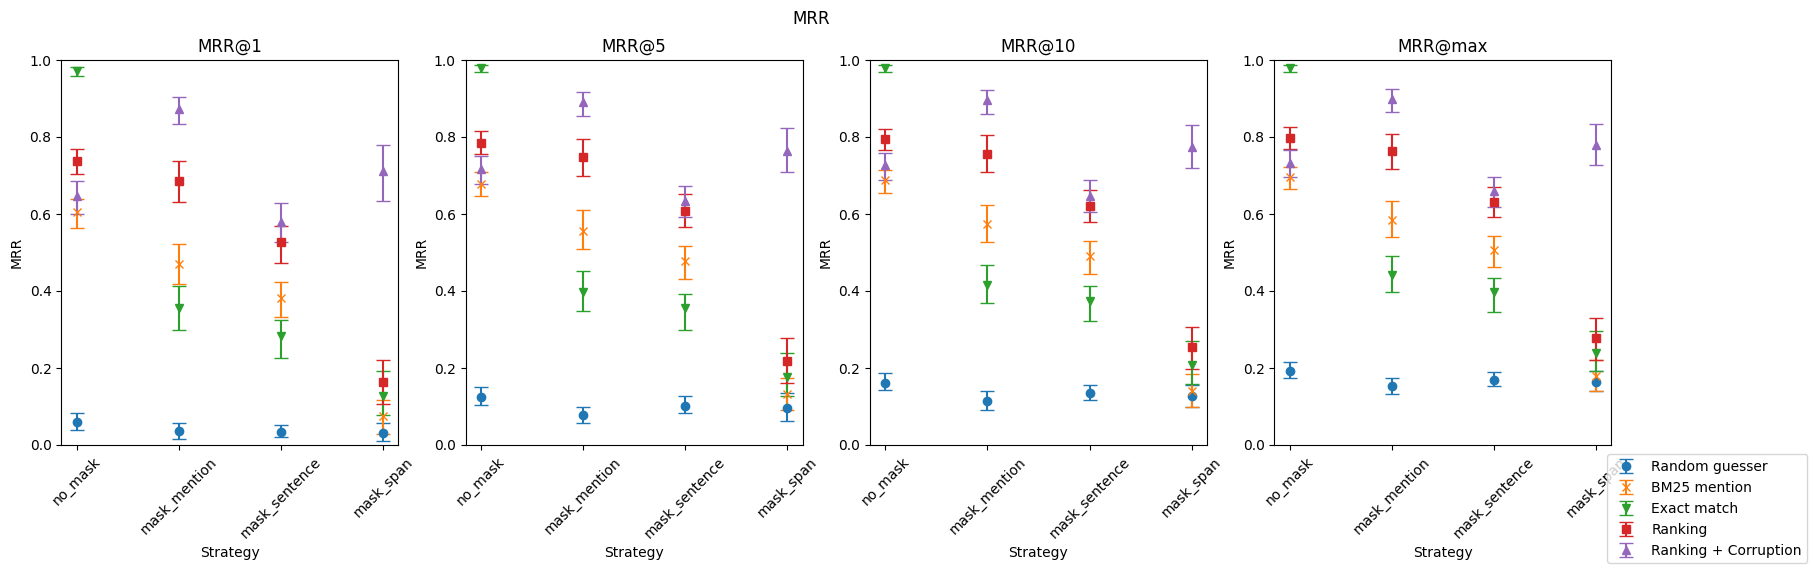

In [44]:
# Plot MRR stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the MRR on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('MRR')    
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('MRR')
    ax.set_title(f"MRR@{list(mrr_at_k_random.keys())[axs.tolist().index(ax)]}")
    
for i, k in enumerate(mrr_at_k_random.keys()):
    axs[i].errorbar(strategies, [stratified_mrr_at_k_random[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_random[s][k]['score'] - stratified_mrr_at_k_random[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_random[s][k]['cl'][1] - stratified_mrr_at_k_random[s][k]['score'] for s in strategies]], label='Random guesser', marker='o', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_mrr_at_k_bm25_mention[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_bm25_mention[s][k]['score'] - stratified_mrr_at_k_bm25_mention[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_bm25_mention[s][k]['cl'][1] - stratified_mrr_at_k_bm25_mention[s][k]['score'] for s in strategies]], label='BM25 mention', marker='x', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_mrr_at_k_exact[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_exact[s][k]['score'] - stratified_mrr_at_k_exact[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_exact[s][k]['cl'][1] - stratified_mrr_at_k_exact[s][k]['score'] for s in strategies]], label='Exact match', marker='v', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_mrr_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_model_softmax_no_corruption[s][k]['score'] - stratified_mrr_at_k_model_softmax_no_corruption[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_model_softmax_no_corruption[s][k]['cl'][1] - stratified_mrr_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies]], label='Ranking', marker='s', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] - stratified_mrr_at_k_model_softmax_corruption[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_model_softmax_corruption[s][k]['cl'][1] - stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] for s in strategies]], label='Ranking + Corruption', marker='^', capsize=5, linestyle='None')
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

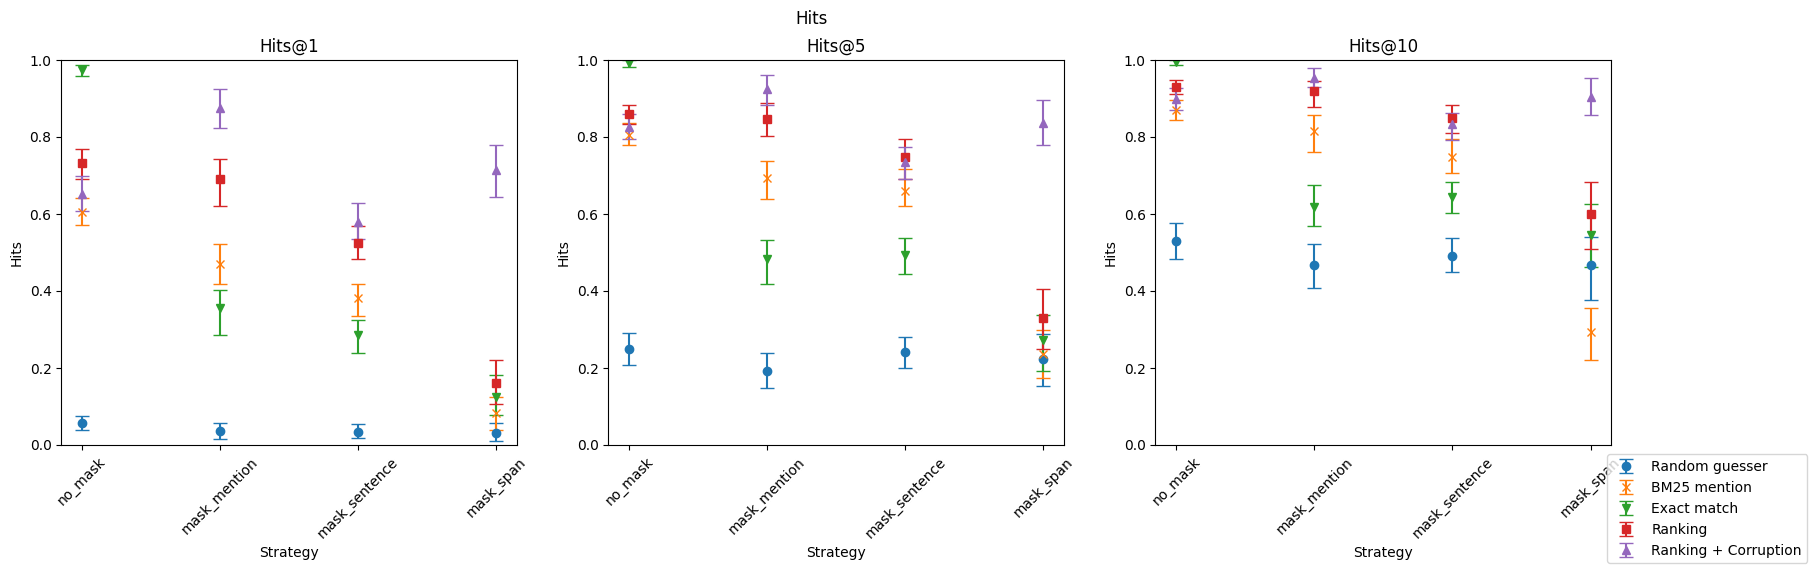

In [45]:
# Plot Hits stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the hits on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Hits')
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Hits')
    ax.set_title(f"Hits@{list(hits_at_k_random.keys())[axs.tolist().index(ax)]}")

for i, k in enumerate(hits_at_k_random.keys()):
    axs[i].errorbar(strategies, [stratified_hits_at_k_random[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_random[s][k]['score'] - stratified_hits_at_k_random[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_random[s][k]['cl'][1] - stratified_hits_at_k_random[s][k]['score'] for s in strategies]], label='Random guesser', marker='o', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_hits_at_k_bm25_mention[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_bm25_mention[s][k]['score'] - stratified_hits_at_k_bm25_mention[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_bm25_mention[s][k]['cl'][1] - stratified_hits_at_k_bm25_mention[s][k]['score'] for s in strategies]], label='BM25 mention', marker='x', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_hits_at_k_exact[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_exact[s][k]['score'] - stratified_hits_at_k_exact[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_exact[s][k]['cl'][1] - stratified_hits_at_k_exact[s][k]['score'] for s in strategies]], label='Exact match', marker='v', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_hits_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_model_softmax_no_corruption[s][k]['score'] - stratified_hits_at_k_model_softmax_no_corruption[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_model_softmax_no_corruption[s][k]['cl'][1] - stratified_hits_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies]], label='Ranking', marker='s', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_hits_at_k_model_softmax_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_model_softmax_corruption[s][k]['score'] - stratified_hits_at_k_model_softmax_corruption[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_model_softmax_corruption[s][k]['cl'][1] - stratified_hits_at_k_model_softmax_corruption[s][k]['score'] for s in strategies]], label='Ranking + Corruption', marker='^', capsize=5, linestyle='None')
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

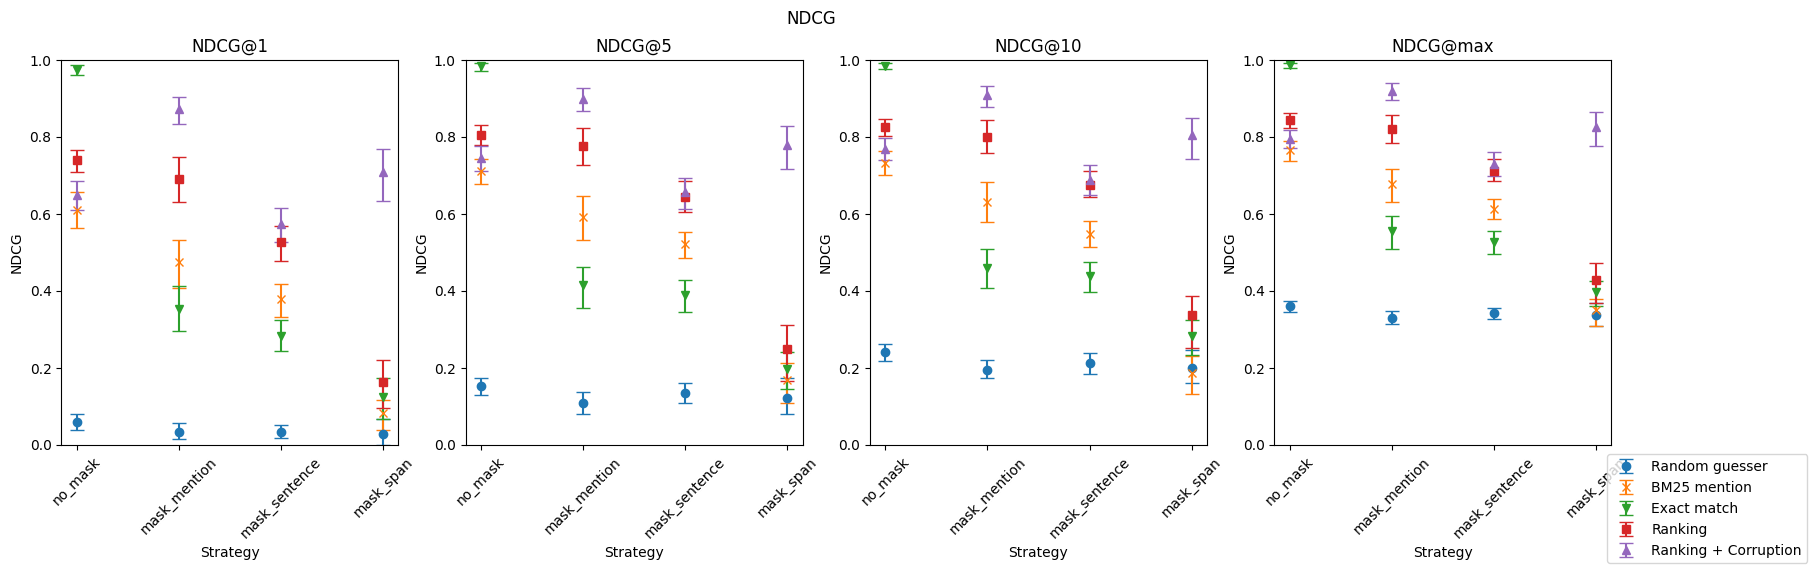

In [46]:
# Plot NDCG stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the ndcg on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('NDCG')

for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('NDCG')
    ax.set_title(f"NDCG@{list(ndcg_at_k_random.keys())[axs.tolist().index(ax)]}")

for i, k in enumerate(ndcg_at_k_random.keys()):
    axs[i].errorbar(strategies, [stratified_ndcg_at_k_random[s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k_random[s][k]['score'] - stratified_ndcg_at_k_random[s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k_random[s][k]['cl'][1] - stratified_ndcg_at_k_random[s][k]['score'] for s in strategies]], label='Random guesser', marker='o', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_ndcg_at_k_bm25_mention[s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k_bm25_mention[s][k]['score'] - stratified_ndcg_at_k_bm25_mention[s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k_bm25_mention[s][k]['cl'][1] - stratified_ndcg_at_k_bm25_mention[s][k]['score'] for s in strategies]], label='BM25 mention', marker='x', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_ndcg_at_k_exact[s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k_exact[s][k]['score'] - stratified_ndcg_at_k_exact[s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k_exact[s][k]['cl'][1] - stratified_ndcg_at_k_exact[s][k]['score'] for s in strategies]], label='Exact match', marker='v', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_ndcg_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k_model_softmax_no_corruption[s][k]['score'] - stratified_ndcg_at_k_model_softmax_no_corruption[s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k_model_softmax_no_corruption[s][k]['cl'][1] - stratified_ndcg_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies]], label='Ranking', marker='s', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_ndcg_at_k_model_softmax_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k_model_softmax_corruption[s][k]['score'] - stratified_ndcg_at_k_model_softmax_corruption[s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k_model_softmax_corruption[s][k]['cl'][1] - stratified_ndcg_at_k_model_softmax_corruption[s][k]['score'] for s in strategies]], label='Ranking + Corruption', marker='^', capsize=5, linestyle='None')
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')    

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Additional plots

## Compare the full model with the model with random section names

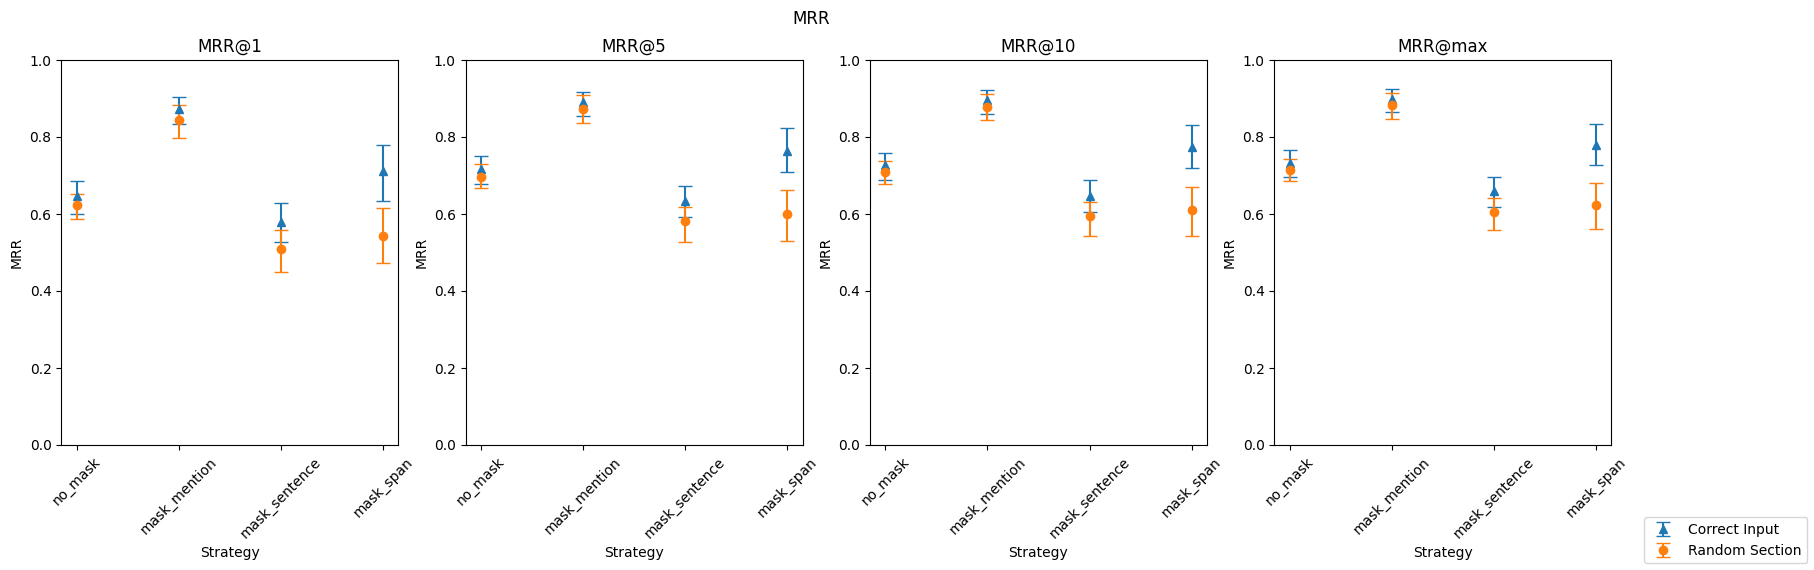

In [47]:
# Plot MRR stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the hits on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('MRR')
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('MRR')
    ax.set_title(f"MRR@{list(mrr_at_k_random.keys())[axs.tolist().index(ax)]}")

for i, k in enumerate(mrr_at_k_random.keys()):
    axs[i].errorbar(strategies, [stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] - stratified_mrr_at_k_model_softmax_corruption[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_model_softmax_corruption[s][k]['cl'][1] - stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] for s in strategies]], label='Correct Input', marker='^', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_mrr_at_k_model_random_section[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_model_random_section[s][k]['score'] - stratified_mrr_at_k_model_random_section[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_model_random_section[s][k]['cl'][1] - stratified_mrr_at_k_model_random_section[s][k]['score'] for s in strategies]], label='Random Section', marker='o', capsize=5, linestyle='None')
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

## Compare Vanilla BM25 with Mention-Aware BM25

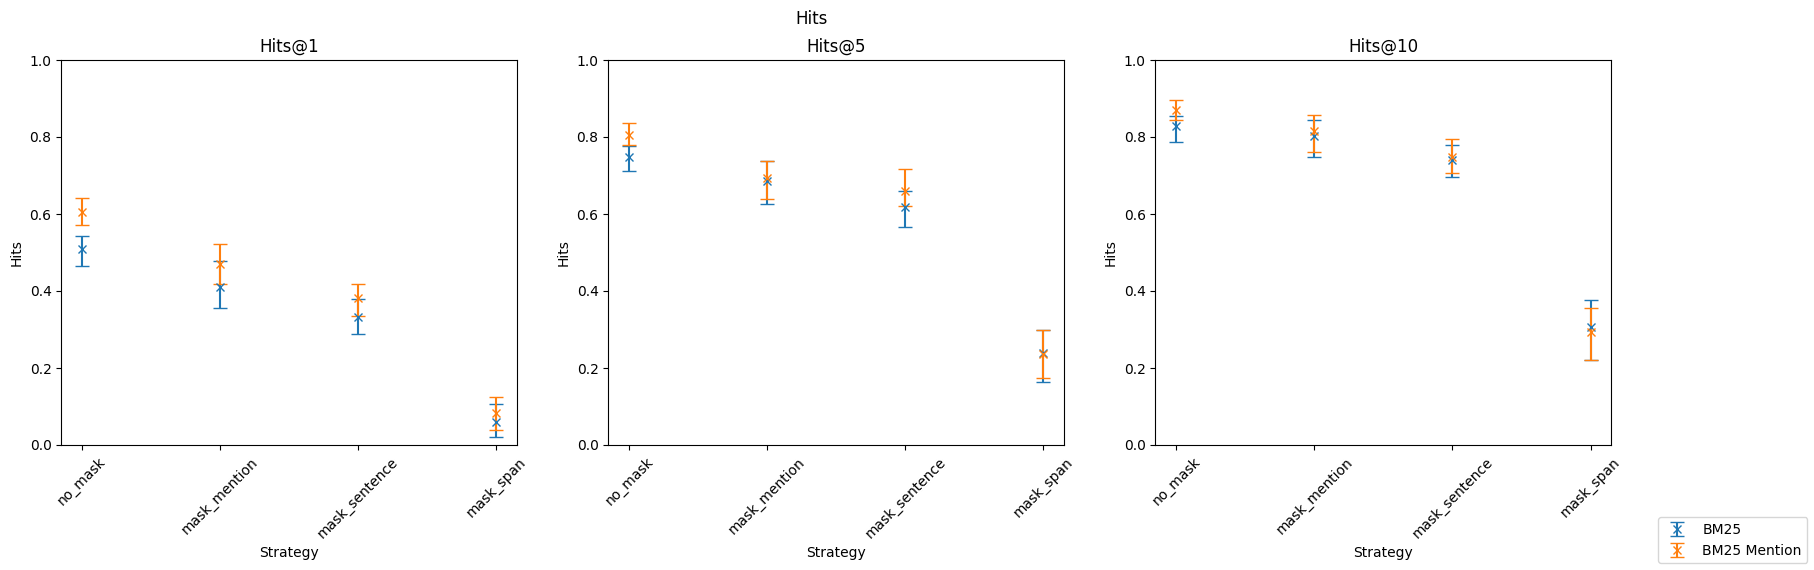

In [48]:
# Plot Hits stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the hits on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Hits')
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Hits')
    ax.set_title(f"Hits@{list(hits_at_k_random.keys())[axs.tolist().index(ax)]}")

for i, k in enumerate(hits_at_k_random.keys()):
    axs[i].errorbar(strategies, [stratified_hits_at_k_bm25[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_bm25[s][k]['score'] - stratified_hits_at_k_bm25[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_bm25[s][k]['cl'][1] - stratified_hits_at_k_bm25[s][k]['score'] for s in strategies]], label='BM25', marker='x', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_hits_at_k_bm25_mention[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_bm25_mention[s][k]['score'] - stratified_hits_at_k_bm25_mention[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_bm25_mention[s][k]['cl'][1] - stratified_hits_at_k_bm25_mention[s][k]['score'] for s in strategies]], label='BM25 Mention', marker='x', capsize=5, linestyle='None')
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)